## Evaluation of name onomastics

We use Namsor's origin and diaspora APIs to explore the origin of names in our dataset and evaluate the potential bias of the data set and the services in the benchmark.

In [286]:
import requests
import json
from pandas.io.json import json_normalize
import pandas as pd
import urllib
from os.path import join

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
sns.set(color_codes=True)

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from config import NAMSOR_USER, NAMSOR_PW

headers = {
    'X-Channel-Secret': NAMSOR_PW,
    'X-Channel-User': NAMSOR_USER,
    'Accept': 'application/json',
}

In [5]:
# testing
response = requests.get('https://api.namsor.com/onomastics/api/json/origin/Caitriona/Kennedy', headers=headers)
response.text

'{"country":"IE","countryAlt":"GB","score":3.6568307047142934,"script":"LATIN","countryFirstName":"IE","countryLastName":"GB","scoreFirstName":2.373716624391118,"scoreLastName":2.53655126308492,"subRegion":"Northern Europe","region":"Europe","topRegion":"Europe","countryName":"Ireland"}'

In [ ]:
response.status_code

In [30]:
# Test how API reacts to usage of hyphens
response = requests.get('https://api.namsor.com/onomastics/api/json/origin/sheau-chiou/chao', headers=headers)
response.text

'{"country":"CN","countryAlt":"CN","score":3.327766060755152,"script":"LATIN","countryFirstName":"TW","countryLastName":"TW","scoreFirstName":-0.023863777936456505,"scoreLastName":2.531070718432645,"subRegion":"Eastern Asia","region":"Asia","topRegion":"Asia","countryName":"China"}'

In [31]:
# Test how API reacts to usage of spaces
response = requests.get('https://api.namsor.com/onomastics/api/json/origin/sheau chiou/chao', headers=headers)
response.text

In [57]:
# test usage of diacritics
response = requests.get('https://api.namsor.com/onomastics/api/json/origin/marià/misić', 
                        headers=headers)
response.text

'{"country":"RS","countryAlt":"RS","score":-0.3349759457401318,"script":"LATIN","countryFirstName":"ES","countryLastName":"RS","scoreFirstName":-0.14794969736484045,"scoreLastName":0.3992291149412908,"subRegion":"Southern Europe","region":"Europe","topRegion":"Europe","countryName":"Serbia"}'

In [66]:
json.loads(response.text)

{'country': 'RS',
 'countryAlt': 'RS',
 'countryFirstName': 'ES',
 'countryLastName': 'RS',
 'countryName': 'Serbia',
 'region': 'Europe',
 'score': -0.3349759457401318,
 'scoreFirstName': -0.14794969736484045,
 'scoreLastName': 0.3992291149412908,
 'script': 'LATIN',
 'subRegion': 'Southern Europe',
 'topRegion': 'Europe'}

In [70]:
json_normalize(json.loads(response.text))

,country,countryAlt,countryFirstName,countryLastName,countryName,region,score,scoreFirstName,scoreLastName,script,subRegion,topRegion
0,RS,RS,ES,RS,Serbia,Europe,-0.334976,-0.14795,0.399229,LATIN,Southern Europe,Europe


### Read data file with all names

In [6]:
data = pd.read_csv('../test_data/raw_data/all.csv', keep_default_na=False)

In [7]:
data.shape

(7076, 6)

In [8]:
data.sample(3)

,first_name,middle_name,last_name,full_name,gender,origin
6111,shinsuke,,sato,shinsuke sato,u,wos
6546,makoto,,mizunami,makoto mizunami,m,wos
2146,levita,,hidayat,levita hidayat,f,pubmed


###  Fetch origin predictions

In [71]:
origin = []
origin_url = 'https://api.namsor.com/onomastics/api/json/origin/'
for i, row in data.iterrows():
    if row['middle_name'] == '':
        url = origin_url + row['first_name'] + '/' + row['last_name']
    else:
        url = origin_url + row['first_name'] + '-' + row['middle_name'] + '/' + row['last_name']
    r = requests.get(url, headers=headers)
    if r.status_code == 200:
        origin.append(json.loads(r.text))
    else:
        print(row)
        origin.append({})

In [73]:
len(origin)

7076

In [74]:
origin_df = json_normalize(origin)

In [43]:
origin_df['full_name'] = data['full_name']
origin_df['gender'] = data['gender']
origin_df['source'] = data['origin']

In [48]:
origin_df.sample(3)

,country,countryAlt,countryFirstName,countryLastName,countryName,region,score,scoreFirstName,scoreLastName,script,subRegion,topRegion,full_name,gender,source
5901,IE,LR,IE,GB,Ireland,Europe,2.969702,2.701208,1.029097,LATIN,Northern Europe,Europe,timothy farley,u,wos
887,GB,GB,UG,GB,United Kingdom of Great Britain and Northern I...,Europe,1.936933,2.020439,1.319162,LATIN,Northern Europe,Europe,patricia clee,u,genderize_r_authors
1843,DE,DE,UG,DE,Germany,Europe,3.170821,1.228249,2.983891,LATIN,Western Europe,Europe,allen dietrich,m,pubmed


In [44]:
origin_df.to_csv("origin_evaluation.csv", sep=';', index=False)

###  Fetch ethnicity predictions

In [9]:
diaspora_url = 'https://api.namsor.com/onomastics/api/json/diaspora/'
diaspora = []
counter = 0

for i, row in data.iterrows():
    counter += 1
    if row['middle_name'] == '':
        url = diaspora_url + row['first_name'] + '/' + row['last_name']
    else:
        url = diaspora_url + row['first_name'] + '-' + row['middle_name'] + '/' + row['last_name']
        
    r = requests.get(url, headers=headers)
    
    if r.status_code == 200:
        diaspora.append(json.loads(r.text))
    else:
        print(row)
        diaspora.append({})

In [91]:
len(diaspora)

7076

In [92]:
diaspora_df = json_normalize(diaspora)

In [45]:
diaspora_df['full_name'] = data['full_name']
diaspora_df['gender'] = data['gender']
diaspora_df['source'] = data['origin']

In [46]:
diaspora_df.sample(5)

,ethno,ethnoAlt,geoCountry,geoCountryAlt,score,script,full_name,gender,source
4146,Chinese,Chinese,TW,TW,5.628998,LATIN,jingchi chen,m,wos
2660,Polish,Polish,US,PL,2.462238,LATIN,pauline mysliwiec,f,pubmed
6443,Irish,British,US,US,1.924885,LATIN,kelly foote,m,wos
372,Somalia,Somalia,GB,SO,3.768971,LATIN,ahmed zeriahi,m,zbmath
3722,Dutch,Dutch,ZA,NL,4.616152,LATIN,mathijs smit,m,wos


In [47]:
diaspora_df.to_csv("diaspora_evaluation.csv", sep=';', index=False)

### Merge origin and ethnicity predictions

In [49]:
origin_df = pd.read_csv("origin_evaluation.csv", sep=';')
diaspora_df = pd.read_csv("diaspora_evaluation.csv", sep=';')

In [50]:
origin_df.columns

Index(['country', 'countryAlt', 'countryFirstName', 'countryLastName',
       'countryName', 'region', 'score', 'scoreFirstName', 'scoreLastName',
       'script', 'subRegion', 'topRegion', 'full_name', 'gender', 'source'],
      dtype='object')

In [51]:
diaspora_df.columns

Index(['ethno', 'ethnoAlt', 'geoCountry', 'geoCountryAlt', 'score', 'script',
       'full_name', 'gender', 'source'],
      dtype='object')

In [52]:
df = origin_df[['full_name', 'gender', 'source', 'countryName', 'country', 'countryAlt', 
                'region', 'subRegion', 'topRegion', 'score']]

In [53]:
df = df.rename({'score': 'score_origin'}, axis='columns')

In [54]:
df = pd.concat([df, diaspora_df[['ethno', 'ethnoAlt', 'geoCountry', 'geoCountryAlt', 'score']]], axis=1)

In [55]:
df = df.rename({'score': 'score_diaspora'}, axis='columns')

In [56]:
df.sample(3)

,full_name,gender,source,countryName,country,countryAlt,region,subRegion,topRegion,score_origin,ethno,ethnoAlt,geoCountry,geoCountryAlt,score_diaspora
2555,joseph mathew,m,pubmed,Ireland,IE,TZ,Europe,Northern Europe,Europe,2.498026,Indian,Irish,US,IE,2.650154
6717,michel faure,m,wos,France,FR,FR,Europe,Western Europe,Europe,3.474327,French,Jewish,CH,FR,3.516748
2360,eswar krishnan,m,pubmed,India,IN,IN,Asia,Southern Asia,Asia,2.978138,Indian,Indian,IN,US,4.141528


### Analysis

In [287]:
df.topRegion.value_counts()

Europe      4338
Asia        2372
Africa       365
Americas       1
Name: topRegion, dtype: int64

In [288]:
# referring to Namsor's evaluations, scores above 0 are reliable for Europe, Asia and Africa
len(df[df.score_origin <= 0])

210

In [289]:
# check whether a data source is particularly affected by the low origin score
count_low_score = df[df.score_origin <= 0].groupby('source')['full_name'].count()
count_all = df.groupby('source')['full_name'].count()
count_low_score.divide(count_all)

source
genderize_r_authors    0.031746
genderize_r_titles     0.036170
pubmed                 0.025615
wos                    0.032547
zbmath                 0.012500
Name: full_name, dtype: float64

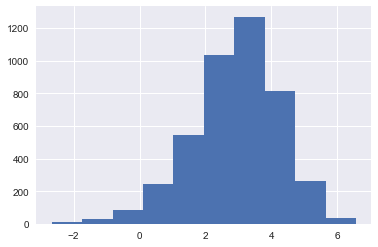

In [290]:
df[df.topRegion == 'Europe']['score_origin'].hist()

#### Distribution of regions by data source

In [291]:
origin_by_source = df[df.score_origin > 0].groupby(['topRegion', 'source']).count().\
unstack('topRegion')['full_name'].fillna(0)
origin_by_source

topRegion,Africa,Asia,Europe
source,,,
genderize_r_authors,35,58,456
genderize_r_titles,27,50,376
pubmed,108,462,1332
wos,149,1609,1809
zbmath,15,125,255


In [292]:
# normalize
origin_by_source['sum'] = [origin_by_source.loc[i,:].sum() for i in origin_by_source.index]
origin_by_source = origin_by_source.apply(lambda x: x/x['sum'], axis=1)

In [293]:
origin_by_source

topRegion,Africa,Asia,Europe,sum
source,,,,
genderize_r_authors,0.063752,0.105647,0.830601,1.0
genderize_r_titles,0.059603,0.110375,0.830022,1.0
pubmed,0.056782,0.242902,0.700315,1.0
wos,0.041772,0.451079,0.507149,1.0
zbmath,0.037975,0.316456,0.645570,1.0


In [294]:
origin_by_source = origin_by_source.drop(['sum'], axis=1)

[Text(0,0,'  0%'),
 Text(0,0,' 20%'),
 Text(0,0,' 40%'),
 Text(0,0,' 60%'),
 Text(0,0,' 80%'),
 Text(0,0,'100%'),
 Text(0,0,'120%')]

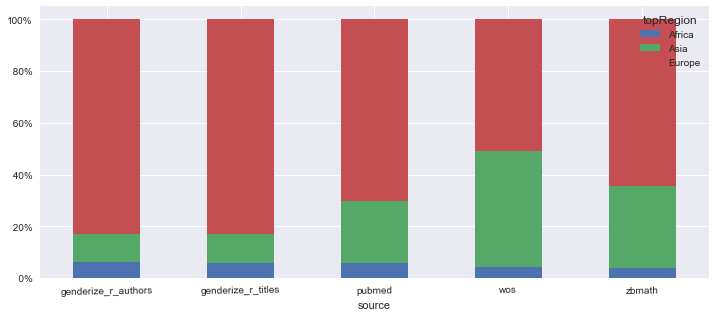

In [295]:
fig, ax = plt.subplots(figsize=(12,5))
origin_by_source.plot(ax=ax, kind='bar', stacked=True, rot=1)
# add %-signs to y-axis
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

* all data sources show only a few peercent of African names. 
* For `wos` approximately half of the names are from Asia and the other half have European origin; for the other data sources, names of European origin predominate, in particular for the `genderize_r` data sources 

#### Distribution of sub-regions by data source

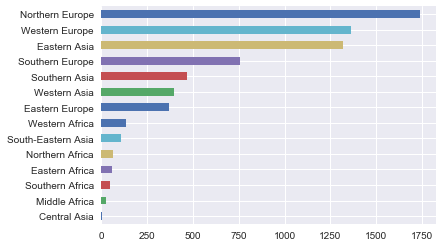

In [296]:
df[df.score_origin > 0].subRegion.value_counts().sort_values().plot(kind='barh')

[Text(0,0,'  0%'),
 Text(0,0,' 20%'),
 Text(0,0,' 40%'),
 Text(0,0,' 60%'),
 Text(0,0,' 80%'),
 Text(0,0,'100%'),
 Text(0,0,'120%')]

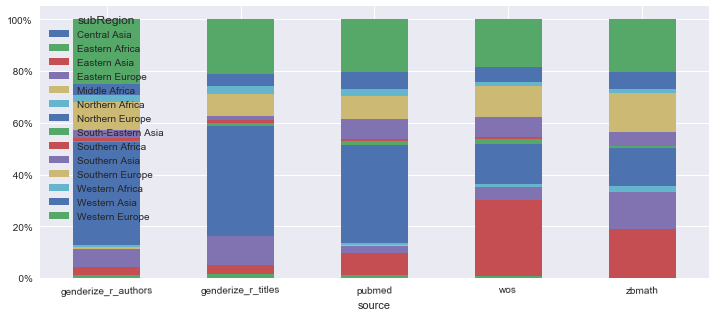

In [297]:
origin_by_source = df[df.score_origin > 0].groupby(['subRegion', 'source']).count().\
unstack('subRegion')['full_name'].fillna(0)
# normalize
origin_by_source['sum'] = [origin_by_source.loc[i,:].sum() for i in origin_by_source.index]
origin_by_source = origin_by_source.apply(lambda x: x/x['sum'], axis=1)
origin_by_source = origin_by_source.drop(['sum'], axis=1)

fig, ax = plt.subplots(figsize=(12,5))
origin_by_source.plot(ax=ax, kind='bar', stacked=True, rot=1)
# add %-signs to y-axis
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

#### Distribution of countries by data source

In [298]:
origin_by_source = df[df.score_origin > 0].groupby(['countryName', 'source']).count().\
unstack('countryName')['full_name'].fillna(0)
# normalize
origin_by_source['sum'] = [origin_by_source.loc[i,:].sum() for i in origin_by_source.index]
origin_by_source = origin_by_source.apply(lambda x: x/x['sum'], axis=1)
origin_by_source = origin_by_source.drop(['sum'], axis=1)

In [299]:
origin_by_source

countryName,Afghanistan,Albania,Algeria,Armenia,Austria,Azerbaijan,Bahrain,Bangladesh,Belarus,Belgium,...,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom of Great Britain and Northern Ireland,Uzbekistan,Viet Nam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
genderize_r_authors,0.000000,0.000000,0.001821,0.001821,0.041894,0.00000,0.000000,0.001821,0.001821,0.007286,...,0.009107,0.000000,0.000000,0.000000,0.222222,0.001821,0.000000,0.000000,0.000000,0.001821
genderize_r_titles,0.000000,0.000000,0.000000,0.000000,0.024283,0.00000,0.000000,0.000000,0.000000,0.006623,...,0.000000,0.006623,0.002208,0.000000,0.264901,0.002208,0.000000,0.000000,0.000000,0.000000
pubmed,0.000526,0.001052,0.001052,0.002629,0.024185,0.00000,0.000526,0.004732,0.001052,0.013670,...,0.004206,0.004732,0.002103,0.000000,0.187697,0.000526,0.001577,0.000000,0.000000,0.000000
wos,0.001121,0.000561,0.001121,0.001402,0.015980,0.00028,0.000841,0.005607,0.001121,0.011214,...,0.026072,0.001121,0.001402,0.000561,0.089711,0.000280,0.005046,0.001402,0.001121,0.000280
zbmath,0.000000,0.000000,0.007595,0.000000,0.017722,0.00000,0.000000,0.002532,0.002532,0.005063,...,0.025316,0.000000,0.010127,0.000000,0.068354,0.000000,0.002532,0.005063,0.000000,0.000000


In [300]:
# print the most frequent countries per data source and their cummulative sum
no_countries = 10
for i, row in origin_by_source.iterrows():
    print("data source: ", i)
    row_sorted = row.sort_values(ascending=False)
    print(row_sorted[:no_countries].cumsum(axis=0))


data source:  genderize_r_authors
countryName
United Kingdom of Great Britain and Northern Ireland    0.222222
Ireland                                                 0.369763
Germany                                                 0.495446
Italy                                                   0.542805
France                                                  0.586521
Austria                                                 0.628415
Poland                                                  0.664845
Israel                                                  0.692168
India                                                   0.717668
Spain                                                   0.743169
Name: genderize_r_authors, dtype: float64
data source:  genderize_r_titles
countryName
United Kingdom of Great Britain and Northern Ireland    0.264901
Ireland                                                 0.388521
Germany                                                 0.501104
Russian Federation    

* for 3 out of 5 data sources, UK is the most frequent country; it is always among the top 3. Ireland is for all data sources except `wos` also among the top 6. Overall, English speaking names are the most frequent ones.
* Germany among the top 3 for all data sets
* both `genderize_r` data sources and `pubmed` have the same top 3 countries: UK, Ireland, Germany
* Both `genderize_r` datasets are very Euro-centric. Almost no Asian country among the top 10
* Data source `wos` has a particularly high share of Asian names: China is at pos. 1, Japan at pos. 3 and Korea at pos. 6
* `genderize_r` data sources show the lowest variability: top 3 countries cover 50% of all names and the top 10 cover ~75%. The highest variability is in the smallest data set `zbmath`, where the top 3 countries are responsible for 26% of all names and the top 10 cover 60%.

### check data sample for quality of `origin` inference 

In [301]:
# sample 50 names and check manually
sample = df[df.score_origin > 0].sample(50, random_state=1)

In [302]:
sample[['full_name', 'countryName', 'subRegion', 'topRegion', 'score_origin']]

,full_name,countryName,subRegion,topRegion,score_origin
2932,paul rutgeerts,Belgium,Western Europe,Europe,3.854667
5474,christopher ta,Viet Nam,South-Eastern Asia,Asia,1.636782
964,ian morison,United Kingdom of Great Britain and Northern I...,Northern Europe,Europe,2.132824
5373,alexander voityuk,Russian Federation,Eastern Europe,Europe,3.562407
449,robert burton,Ireland,Northern Europe,Europe,3.201207
6606,mitsuru okuno,Japan,Eastern Asia,Asia,3.753080
4455,dongmei qin,China,Eastern Asia,Asia,4.575318
253,mario perez-jimenez,Spain,Southern Europe,Europe,2.642884
3568,alyne simoes,France,Western Europe,Europe,0.826543
5384,andrew mackay,United Kingdom of Great Britain and Northern I...,Northern Europe,Europe,3.325402


The predicted origin seem fine for this data sample (at least in terms of subRegion and topRegion).

## Evaluate errors w.r.t. origin

In [303]:
from evaluators import *
from evaluator import *
from config import DIR_PATH


REGISTERED_EVALUATORS = [GenderAPIEvaluator, GenderAPIFullEvaluator, \
    NameAPIEvaluator, NameAPIFullEvaluator, GenderGuesserEvaluator, \
    GenderizeIoEvaluator, NamSorEvaluator]

In [285]:
# method for computing all errors for a specific eror matrix
def compute_all_errors(e, cm):
    error_with_unknown = e.compute_error_with_unknown(cm)
    error_without_unknown = e.compute_error_without_unknown(cm)
    error_unknown = e.compute_error_unknown(cm)
    error_gender_bias = e.compute_error_gender_bias(cm)
    weighted_error = e.compute_weighted_error(cm)
    return [error_with_unknown, error_without_unknown, error_gender_bias, error_unknown, weighted_error]

In [280]:
error_by_country_and_service = {}
error_names = ['errorCoded', 'errorCodedWithoutNA', 'errorGenderBias', 'naCoded', 'WeightedError']

for s in REGISTERED_EVALUATORS: 
    region_to_errors = {}
    evaluator = s('all')
    eval_name = evaluator.gender_evaluator
    evaluator.load_data(evaluated=True)
    evaluator._translate_api_response()
    evaluator.test_data['topRegion'] = df['topRegion']
    evaluator.test_data['score_origin'] = df['score_origin']
    evaluator.test_data = evaluator.test_data[evaluator.test_data['score_origin']>0]
    errors = evaluator.compute_all_errors()
    for item in origin_df['topRegion'].unique():
        conf_matrix = evaluator.compute_confusion_matrix(evaluator.test_data[evaluator.test_data.topRegion==item])
        errors = compute_all_errors(evaluator, conf_matrix)
        region_to_errors[item] = errors
        d = pd.DataFrame.from_dict(region_to_errors, orient='index')
        d.columns = error_names
        d.dropna(inplace=True)
    service_to_all_errors[eval_name] = d.transpose()
    
error_by_country = {}
for e_type in error_names:
    results = []
    for service, error_df in service_to_all_errors.items():
        d = pd.DataFrame(error_df.loc[e_type])
        d.columns = [service]
        d = d.transpose()
        results.append(d)

    error_by_country[e_type] = pd.concat(results)


/opt/projects/meins/ICSU_GenderGap_Project/name_gender_inference/name_gender_inference/evaluator.py:272: RuntimeWarning: invalid value encountered in long_scalars
  error_with_unknown = (true_f_and_m - true_pred_f_and_m) / true_f_and_m
/opt/projects/meins/ICSU_GenderGap_Project/name_gender_inference/name_gender_inference/evaluator.py:261: RuntimeWarning: invalid value encountered in long_scalars
  conf_matrix.loc['f', 'f_pred'] + conf_matrix.loc['m', 'm_pred'])
/opt/projects/meins/ICSU_GenderGap_Project/name_gender_inference/name_gender_inference/evaluator.py:281: RuntimeWarning: invalid value encountered in long_scalars
  error_unknown = (conf_matrix.loc['f', 'u_pred'] + conf_matrix.loc['m', 'u_pred']) / true_f_and_m
/opt/projects/meins/ICSU_GenderGap_Project/name_gender_inference/name_gender_inference/evaluator.py:291: RuntimeWarning: invalid value encountered in long_scalars
  conf_matrix.loc['m', 'f_pred'] + conf_matrix.loc['m', 'm_pred'])
/opt/projects/meins/ICSU_GenderGap_Project

In [228]:
service_to_all_errors['name_api']

,errorCoded,errorCodedWithoutNA,errorGenderBias,naCoded,WeightedError
Europe,0.126101,0.024285,0.005841,0.104350,0.046503
Africa,0.250896,0.045662,0.027397,0.215054,0.095238
Asia,0.434475,0.088487,0.010466,0.379575,0.187860


In [282]:
error_by_country['WeightedError']

,Europe,Africa,Asia
name_api,0.046503,0.095238,0.187860
genderize_io,0.027746,0.063670,0.171761
gender_api_full,0.065191,0.104116,0.157860
namsor,0.022305,0.048140,0.156260
gender_api,0.022702,0.048306,0.125532
gender_guesser,0.027392,0.086580,0.211946
name_api_full,0.027778,0.064720,0.166667
